# San Francisco Rental Prices Dashboard

In this notebook, you will compile the visualizations from the previous analysis into functions that can be used for a Panel dashboard.

In [17]:
# imports
import panel as pn
pn.extension('plotly')
import plotly.express as px
import pandas as pd
import hvplot.pandas
import matplotlib.pyplot as plt
import os
from pathlib import Path
from dotenv import load_dotenv

In [18]:
# Read the Mapbox API key
load_dotenv()
map_box_api = os.environ.get("mapbox")
px.set_mapbox_access_token(map_box_api)

# Import Data

In [19]:
# Import the necessary CSVs to Pandas DataFrames

sfo_neigh_df = pd.read_csv("Data/sfo_neighborhoods_census_data.csv", index_col="year")

neigh_loc_df = pd.read_csv("Data/neighborhoods_coordinates.csv")

- - -

## Panel Visualizations

In this section, you will copy the code for each plot type from your analysis notebook and place it into separate functions that Panel can use to create panes for the dashboard. 

These functions will convert the plot object to a Panel pane.

Be sure to include any DataFrame transformation/manipulation code required along with the plotting code.

Return a Panel pane object from each function that can be used to build the dashboard.

Note: Remove any `.show()` lines from the code. We want to return the plots instead of showing them. The Panel dashboard will then display the plots.

In [20]:
# Define Panel Visualization Functions
def housing_units_per_year():
    """Housing Units Per Year."""
    
    hous_unit_mean = sfo_neigh_df["housing_units"].groupby(sfo_neigh_df.index).mean()

    fig_hous_unit = plt.figure()
    plot_hous_unit = hous_unit_mean.plot.bar()
    plot_hous_unit.set_xlabel("Year")
    plot_hous_unit.set_ylabel("Housing Units")
    plot_hous_unit.set_title("Housing Units in San Francisco from 2010 to 2016")

    # Optional Challenge: Use the min, max, and std to scale the y limits of the chart
    hous_unit_std = hous_unit_mean.std()
    hous_unit_min = hous_unit_mean.min()
    hous_unit_max = hous_unit_mean.max()

    plot_hous_unit.set_ylim(
        hous_unit_min - hous_unit_std, hous_unit_max + hous_unit_std
    )
    plt.close(fig_hous_unit)
    return pn.pane.Matplotlib(fig_hous_unit, tight=True)

def average_gross_rent():
    """Average Gross Rent in San Francisco Per Year."""
    
    avg_gross_rent = sfo_neigh_df["gross_rent"].groupby(sfo_neigh_df.index).mean()

    fig_aver_price_by_sqr = plt.figure()
    plot_aver_gross_rent = avg_gross_rent.plot(color='red')
    plot_aver_gross_rent.set_xlabel("Year")
    plot_aver_gross_rent.set_ylabel("Gross Rent")
    plot_aver_gross_rent.set_title("Average Gross Rent in San Francisco Per Year")


    plt.close(fig_aver_price_by_sqr)
    return pn.pane.Matplotlib(fig_aver_price_by_sqr, tight=True)
    



def average_sales_price():
    """Average Sales Price Per Year."""
    
    avg_price_by_sqr = sfo_neigh_df["sale_price_sqr_foot"].groupby(sfo_neigh_df.index).mean()

    fig_aver_price_by_sqr = plt.figure()
    plot_aver_price_by_sqr = avg_price_by_sqr.plot(color='blue')
    plot_aver_price_by_sqr.set_xlabel("Year")
    plot_aver_price_by_sqr.set_ylabel("Average Sales Price per Square Foot")
    plot_aver_price_by_sqr.set_title("Average Sales Price Per Year in San Francisco Per Year.")
    plt.close(fig_aver_price_by_sqr)
    return pn.pane.Matplotlib(fig_aver_price_by_sqr, tight=True)


def average_price_by_neighborhood():
    """Average Prices by Neighborhood."""
    
    sfo_mean_by_year_by_neighbor = sfo_neigh_df.groupby([sfo_neigh_df.index, 'neighborhood']).mean().reset_index()
    sale_price_hvplot = sfo_mean_by_year_by_neighbor.hvplot(
        x='year', 
        y='sale_price_sqr_foot', 
        groupby="neighborhood",
        ylabel='Avg. Sale Price per Square Foot', 
        subplots=True, width=700, height=300
        )
    return sale_price_hvplot



def top_most_expensive_neighborhoods():
    """Top 10 Most Expensive Neighborhoods."""
    sfo_by_neigh = sfo_neigh_df.groupby('neighborhood').mean()
    sfo_by_neigh_10 = sfo_by_neigh.sort_values('sale_price_sqr_foot', ascending = False).head(10).reset_index()
    top_exp_neigh_hvplot = sfo_by_neigh_10.hvplot.bar(
        x="neighborhood",
        y = "sale_price_sqr_foot", rot=90, height=500,
        xlabel = "Neighborhoods", 
        ylabel = "Sale Price per Square Foot",
        title = "Top 10 Most Expensive Neighborhoods in San Francisco")
    return top_exp_neigh_hvplot

def most_expensive_neighborhoods_rent_sales():
    """Comparison of Rent and Sales Prices of Most Expensive Neighborhoods."""   

    sfo_mean_by_year_by_neighbor = sfo_neigh_df.groupby([sfo_neigh_df.index, 'neighborhood']).mean().reset_index()
    sfo_by_neigh = sfo_neigh_df.groupby(by='neighborhood').mean()
    sfo_by_neigh_10 = sfo_by_neigh.sort_values(by='sale_price_sqr_foot', ascending = False).head(10).reset_index()
    data = sfo_by_neigh_10['neighborhood']

    joined = sfo_mean_by_year_by_neighbor[sfo_mean_by_year_by_neighbor['neighborhood'].isin(data)]
    
    most_exp_hvplot = joined.hvplot.bar(
        x='year', 
        y=['sale_price_sqr_foot', 'gross_rent'], 
        groupby= 'neighborhood' ,
        ylabel='Avg. Monthly Rent',
        height=500,
        rot=90)
    return most_exp_hvplot
    
    
def parallel_coordinates():
    """Parallel Coordinates Plot."""

    
    df_costs = sfo_neigh_df.groupby([sfo_neigh_df.index, "neighborhood"]).mean()
    df_costs.reset_index(inplace=True)
    df_expensive_neighborhoods = sfo_neigh_df.groupby(by="neighborhood").mean()
    df_expensive_neighborhoods = df_expensive_neighborhoods.sort_values(
        by="sale_price_sqr_foot", ascending=False
    ).head(10)
    df_expensive_neighborhoods = df_expensive_neighborhoods.reset_index()
    df_expensive_neighborhoods_per_year = df_costs[df_costs["neighborhood"].isin(df_expensive_neighborhoods["neighborhood"])]

    expensive_categories_plot = px.parallel_coordinates(
            df_expensive_neighborhoods_per_year,
            color="sale_price_sqr_foot",
            color_continuous_scale=px.colors.sequential.Inferno,
            title="Parallel Categories Analysis of Most Expensive San Francisco Neighborhoods"
        )
    return expensive_categories_plot

def parallel_categories():
    """Parallel Categories Plot."""
    
    df_costs = sfo_neigh_df.groupby([sfo_neigh_df.index, "neighborhood"]).mean()
    df_costs.reset_index(inplace=True)
    df_expensive_neighborhoods = sfo_neigh_df.groupby(by="neighborhood").mean()
    df_expensive_neighborhoods = df_expensive_neighborhoods.sort_values(
        by="sale_price_sqr_foot", ascending=False
    ).head(10)
    df_expensive_neighborhoods = df_expensive_neighborhoods.reset_index()
    df_expensive_neighborhoods_per_year = df_costs[df_costs["neighborhood"].isin(df_expensive_neighborhoods["neighborhood"])]

    expensive_categories_plot = px.parallel_categories(
            df_expensive_neighborhoods_per_year,
            color="sale_price_sqr_foot",
            color_continuous_scale=px.colors.sequential.Inferno,
            title="Parallel Categories Analysis of Most Expensive San Francisco Neighborhoods"
        )
    return expensive_categories_plot


def neighborhood_map():
    """Neighborhood Map."""

    px.set_mapbox_access_token(map_box_api)
    
    df_all_neighborhoods = sfo_neigh_df.groupby(by="neighborhood").mean()
    df_all_neighborhoods.reset_index(inplace=True)
    df_all_neighborhoods.rename(columns={"neighborhood": "Neighborhood"}, inplace=True)

    df_all_neighborhoods = pd.merge(
        neigh_loc_df, df_all_neighborhoods, on="Neighborhood"
    )

    neighborhood_map = px.scatter_mapbox(
        df_all_neighborhoods,
        lat="Lat",
        lon="Lon",
        size="sale_price_sqr_foot",
        color="gross_rent",
        color_continuous_scale=px.colors.cyclical.IceFire,
        size_max=15,
        zoom=11,
        hover_name="Neighborhood",
        title="Average Sale Price Per Square Foot and Gross Rent in San Francisco",
    )
    plotly_panel = pn.pane.Plotly(neighborhood_map)
    plotly_panel._updates = True
    return plotly_panel



def sunburst():
    """Sunburst Plot."""
    
    df_costs = sfo_neigh_df.groupby([sfo_neigh_df.index, "neighborhood"]).mean()
    df_costs.reset_index(inplace=True)
    df_costs.rename(columns={"level_0": "year"}, inplace=True)
    df_expensive_neighborhoods = sfo_neigh_df.groupby(by="neighborhood").mean()
    df_expensive_neighborhoods = df_expensive_neighborhoods.sort_values(
        by="sale_price_sqr_foot", ascending=False
    ).head(10)
    df_expensive_neighborhoods = df_expensive_neighborhoods.reset_index()
    df_expensive_neighborhoods_per_year = df_costs[df_costs["neighborhood"].isin(df_expensive_neighborhoods["neighborhood"])]
    fig_sunburst = px.sunburst(
        df_expensive_neighborhoods_per_year,
        path=["year", "neighborhood"],
        values='sale_price_sqr_foot',
        color='gross_rent', 
        color_continuous_scale='Blues',
        title="Costs Analysis of Most Expensive neighborhoods in San Francisco per Year",
        height=700)
    plotly_panel_sunburst = pn.pane.Plotly(fig_sunburst)
    plotly_panel_sunburst._updates = True
    return plotly_panel_sunburst


## Panel Dashboard

In this section, you will combine all of the plots into a single dashboard view using Panel. Be creative with your dashboard design!

In [21]:
# Create a Title for the Dashboard
title = pn.pane.Markdown(
    """
# Real Estate Analysis of San Francisco from 2010 to 2016
""",
    width=800,
)

welcome = pn.pane.Markdown(
    """
This dashboard presents a visual analysis of historical prices of house units,
sale price per square foot and gross rent in San Francisco, California
from 2010 to 2016.
You can navigate through the tabs above to explore
more details about the evolution of the real estate market on
The Golden City across these years.
"""
)

# Create a tab layout for the dashboard
tabs = pn.Tabs(
    ("Welcome", pn.Column(welcome, neighborhood_map())),
    ("Yearly Market Analysis", pn.Row(housing_units_per_year(), average_gross_rent(), average_sales_price())),
    ("Neighborhood Analysis", pn.Column(average_price_by_neighborhood(), top_most_expensive_neighborhoods(), most_expensive_neighborhoods_rent_sales())),
    ("Parallel Plots Analysis", pn.Column(parallel_coordinates(), parallel_categories(),width=960)),
    ("Sunburst Plot Analysis", pn.Column(sunburst())),
    )

dashboard = pn.Column(pn.Row(title), tabs, width=900)

## Serve the Panel Dashboard

Traceback (most recent call last):
 File "/home/benjamin/anaconda3/envs/pyvizenv/lib/python3.7/site-packages/pyviz_comms/__init__.py", line 325, in _handle_msg
 self._on_msg(msg)
 File "/home/benjamin/anaconda3/envs/pyvizenv/lib/python3.7/site-packages/panel/viewable.py", line 273, in _on_msg
 doc.unhold()
 File "/home/benjamin/anaconda3/envs/pyvizenv/lib/python3.7/site-packages/bokeh/document/document.py", line 669, in unhold
 self._trigger_on_change(event)
 File "/home/benjamin/anaconda3/envs/pyvizenv/lib/python3.7/site-packages/bokeh/document/document.py", line 1180, in _trigger_on_change
 self._with_self_as_curdoc(event.callback_invoker)
 File "/home/benjamin/anaconda3/envs/pyvizenv/lib/python3.7/site-packages/bokeh/document/document.py", line 1198, in _with_self_as_curdoc
 return f()
 File "/home/benjamin/anaconda3/envs/pyvizenv/lib/python3.7/site-packages/bokeh/util/callback_manager.py", line 161, in invoke
 callback(attr, old, new)
 File "/home/benjamin/anaconda3/envs/pyvizenv/lib/python3.7/site-packages/panel/reactive.py", line 301, in _comm_change
 self._process_events({attr: new})
 File "/home/benjamin/anaconda3/envs/pyvizenv/lib/python3.7/site-packages/panel/reactive.py", line 262, in _process_events
 self.param.set_param(**self_events)
 File "/home/benjamin/anaconda3/envs/pyvizenv/lib/python3.7/site-packages/param/parameterized.py", line 1526, in set_param
 self_._batch_call_watchers()
 File "/home/benjamin/anaconda3/envs/pyvizenv/lib/python3.7/site-packages/param/parameterized.py", line 1665, in _batch_call_watchers
 self_._execute_watcher(watcher, events)
 File "/home/benjamin/anaconda3/envs/pyvizenv/lib/python3.7/site-packages/param/parameterized.py", line 1627, in _execute_watcher
 watcher.fn(*args, **kwargs)
 File "/home/benjamin/anaconda3/envs/pyvizenv/lib/python3.7/site-packages/param/parameterized.py", line 520, in caller
 return function()
 File "/home/benjamin/anaconda3/envs/pyvizenv/lib/python3.7/site-packages/param/parameterized.py", line 351, in _depends
 return func(*args,**kw)
 File "/home/benjamin/anaconda3/envs/pyvizenv/lib/python3.7/site-packages/panel/pane/plotly.py", line 153, in _update_figure_layout
 self._figure.plotly_relayout(self.relayout_data)
 File "/home/benjamin/anaconda3/envs/pyvizenv/lib/python3.7/site-packages/plotly/basedatatypes.py", line 2601, in plotly_relayout
 relayout_changes = self._perform_plotly_relayout(relayout_data)
 File "/home/benjamin/anaconda3/envs/pyvizenv/lib/python3.7/site-packages/plotly/basedatatypes.py", line 2641, in _perform_plotly_relayout
 key_path_str=key_path_str
ValueError: 
Invalid property path 'mapbox._derived' for layout

 


 Traceback (most recent call last):
 File "/home/benjamin/anaconda3/envs/pyvizenv/lib/python3.7/site-packages/pyviz_comms/__init__.py", line 325, in _handle_msg
 self._on_msg(msg)
 File "/home/benjamin/anaconda3/envs/pyvizenv/lib/python3.7/site-packages/panel/viewable.py", line 273, in _on_msg
 doc.unhold()
 File "/home/benjamin/anaconda3/envs/pyvizenv/lib/python3.7/site-packages/bokeh/document/document.py", line 669, in unhold
 self._trigger_on_change(event)
 File "/home/benjamin/anaconda3/envs/pyvizenv/lib/python3.7/site-packages/bokeh/document/document.py", line 1180, in _trigger_on_change
 self._with_self_as_curdoc(event.callback_invoker)
 File "/home/benjamin/anaconda3/envs/pyvizenv/lib/python3.7/site-packages/bokeh/document/document.py", line 1198, in _with_self_as_curdoc
 return f()
 File "/home/benjamin/anaconda3/envs/pyvizenv/lib/python3.7/site-packages/bokeh/util/callback_manager.py", line 161, in invoke
 callback(attr, old, new)
 File "/home/benjamin/anaconda3/envs/pyvizenv/lib/python3.7/site-packages/panel/reactive.py", line 301, in _comm_change
 self._process_events({attr: new})
 File "/home/benjamin/anaconda3/envs/pyvizenv/lib/python3.7/site-packages/panel/reactive.py", line 262, in _process_events
 self.param.set_param(**self_events)
 File "/home/benjamin/anaconda3/envs/pyvizenv/lib/python3.7/site-packages/param/

Column(width=900)
    [0] Row
        [0] Markdown(str, width=800)
    [1] Tabs
        [0] Column
            [0] Markdown(str)
            [1] Plotly(Figure)
        [1] Row
            [0] Matplotlib(Figure, tight=True)
            [1] Matplotlib(Figure, tight=True)
            [2] Matplotlib(Figure, tight=True)
        [2] Column
            [0] Row
                [0] HoloViews(DynamicMap)
                [1] Column
                    [0] WidgetBox
                        [0] Select(margin=(20, 20, 20, 20), name='neighborhood', options=['Alamo Square', ...], value='Alamo Square', width=250)
                    [1] VSpacer()
            [1] HoloViews(Bars)
            [2] Row
                [0] HoloViews(DynamicMap)
                [1] Column
                    [0] WidgetBox
                        [0] Select(margin=(20, 20, 20, 20), name='neighborhood', options=['Cow Hollow', ...], value='Cow Hollow', width=250)
                    [1] VSpacer()
        [3] Column(width=960)
            [0] Plotly(Figure, visible=False)
            [1] Plotly(Figure, visible=False)
        [4] Column
            [0] Plotly(Figure, visible=False)
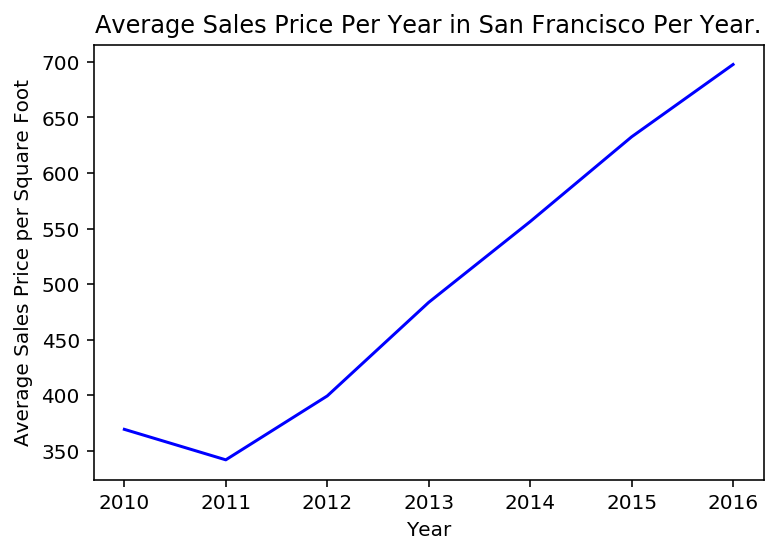
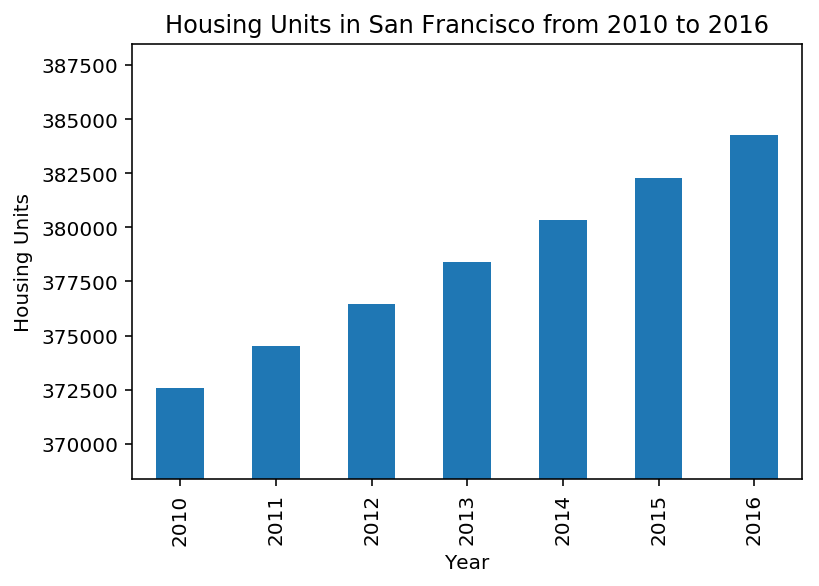
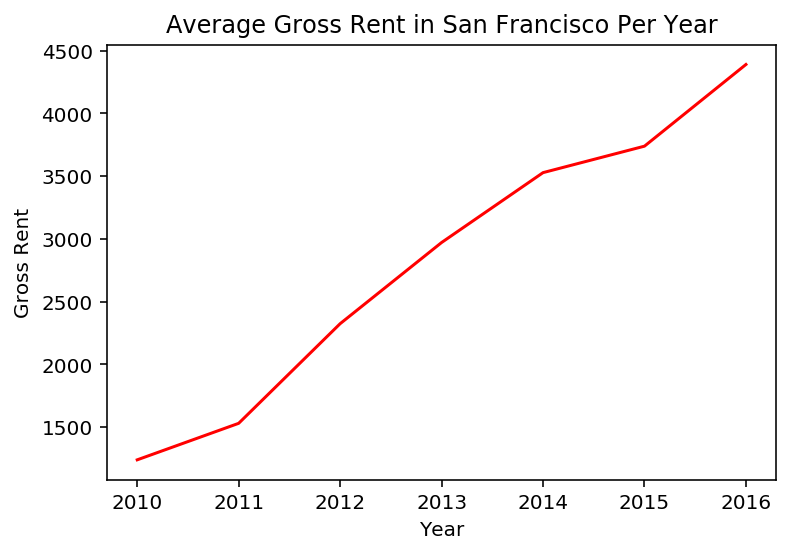

In [22]:
# Serve the# dashboard
dashboard.servable()

# Debugging

Note: Some of the Plotly express plots may not render in the notebook through the panel functions.

However, you can test each plot by uncommenting the following code

Matplotlib(Figure, tight=True)
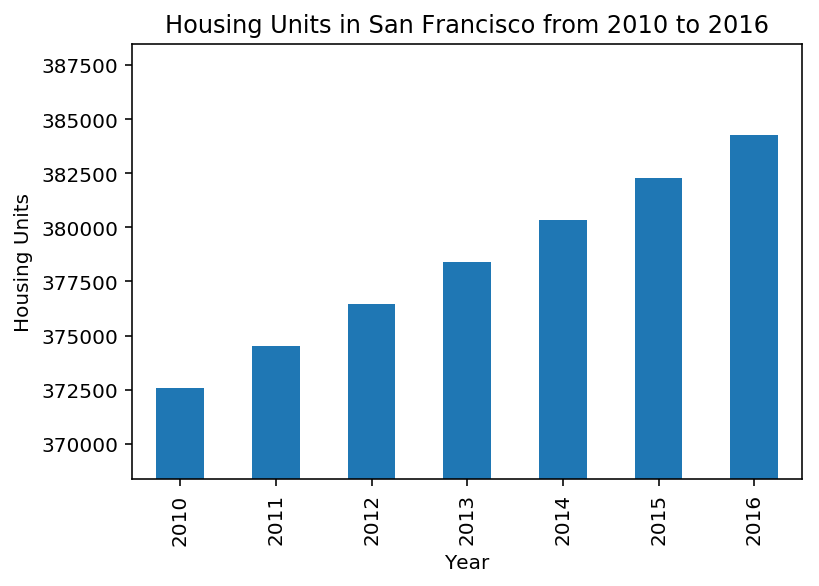

In [23]:
# housing_units_per_year()

housing_units_per_year()

Matplotlib(Figure, tight=True)
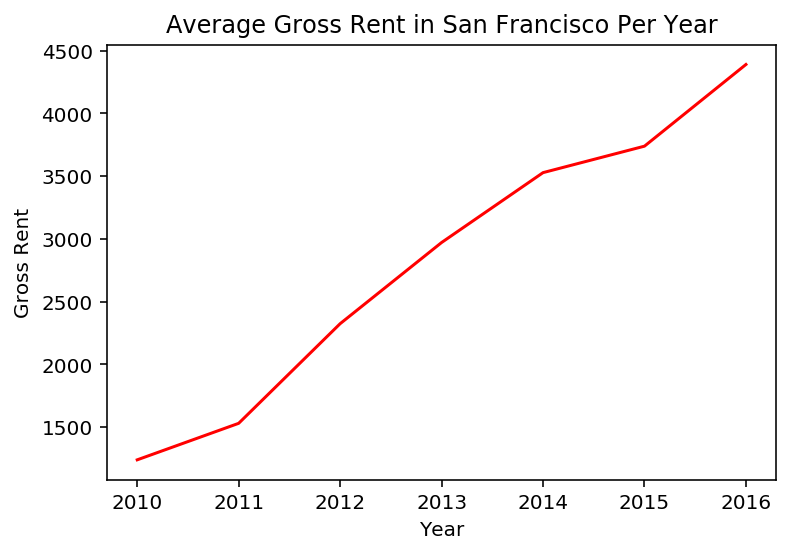

In [24]:
# average_gross_rent()
average_gross_rent()

Matplotlib(Figure, tight=True)
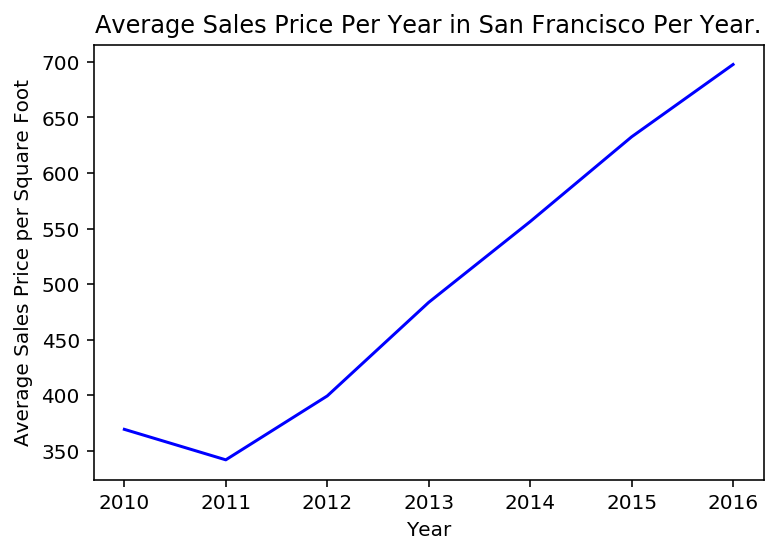

In [25]:
# average_sales_price()
average_sales_price()

In [26]:
# average_price_by_neighborhood()
average_price_by_neighborhood()

:DynamicMap   [neighborhood]
   :Curve   [year]   (sale_price_sqr_foot)

In [27]:
# top_most_expensive_neighborhoods()
top_most_expensive_neighborhoods()

:Bars   [neighborhood]   (sale_price_sqr_foot)

In [28]:
# most_expensive_neighborhoods_rent_sales()
most_expensive_neighborhoods_rent_sales()

:DynamicMap   [neighborhood]
   :Bars   [year,Variable]   (value)

In [33]:
# neighborhood_map().show()
neighborhood_map()

Traceback (most recent call last):
 File "/home/benjamin/anaconda3/envs/pyvizenv/lib/python3.7/site-packages/pyviz_comms/__init__.py", line 325, in _handle_msg
 self._on_msg(msg)
 File "/home/benjamin/anaconda3/envs/pyvizenv/lib/python3.7/site-packages/panel/viewable.py", line 273, in _on_msg
 doc.unhold()
 File "/home/benjamin/anaconda3/envs/pyvizenv/lib/python3.7/site-packages/bokeh/document/document.py", line 669, in unhold
 self._trigger_on_change(event)
 File "/home/benjamin/anaconda3/envs/pyvizenv/lib/python3.7/site-packages/bokeh/document/document.py", line 1180, in _trigger_on_change
 self._with_self_as_curdoc(event.callback_invoker)
 File "/home/benjamin/anaconda3/envs/pyvizenv/lib/python3.7/site-packages/bokeh/document/document.py", line 1198, in _with_self_as_curdoc
 return f()
 File "/home/benjamin/anaconda3/envs/pyvizenv/lib/python3.7/site-packages/bokeh/util/callback_manager.py", line 161, in invoke
 callback(attr, old, new)
 File "/home/benjamin/anaconda3/envs/pyvizenv/lib/python3.7/site-packages/panel/reactive.py", line 301, in _comm_change
 self._process_events({attr: new})
 File "/home/benjamin/anaconda3/envs/pyvizenv/lib/python3.7/site-packages/panel/reactive.py", line 262, in _process_events
 self.param.set_param(**self_events)
 File "/home/benjamin/anaconda3/envs/pyvizenv/lib/python3.7/site-packages/param/parameterized.py", line 1526, in set_param
 self_._batch_call_watchers()
 File "/home/benjamin/anaconda3/envs/pyvizenv/lib/python3.7/site-packages/param/parameterized.py", line 1665, in _batch_call_watchers
 self_._execute_watcher(watcher, events)
 File "/home/benjamin/anaconda3/envs/pyvizenv/lib/python3.7/site-packages/param/parameterized.py", line 1627, in _execute_watcher
 watcher.fn(*args, **kwargs)
 File "/home/benjamin/anaconda3/envs/pyvizenv/lib/python3.7/site-packages/param/parameterized.py", line 520, in caller
 return function()
 File "/home/benjamin/anaconda3/envs/pyvizenv/lib/python3.7/site-packages/param/parameterized.py", line 351, in _depends
 return func(*args,**kw)
 File "/home/benjamin/anaconda3/envs/pyvizenv/lib/python3.7/site-packages/panel/pane/plotly.py", line 153, in _update_figure_layout
 self._figure.plotly_relayout(self.relayout_data)
 File "/home/benjamin/anaconda3/envs/pyvizenv/lib/python3.7/site-packages/plotly/basedatatypes.py", line 2601, in plotly_relayout
 relayout_changes = self._perform_plotly_relayout(relayout_data)
 File "/home/benjamin/anaconda3/envs/pyvizenv/lib/python3.7/site-packages/plotly/basedatatypes.py", line 2641, in _perform_plotly_relayout
 key_path_str=key_path_str
ValueError: 
Invalid property path 'mapbox._derived' for layout

 


 Traceback (most recent call last):
 File "/home/benjamin/anaconda3/envs/pyvizenv/lib/python3.7/site-packages/pyviz_comms/__init__.py", line 325, in _handle_msg
 self._on_msg(msg)
 File "/home/benjamin/anaconda3/envs/pyvizenv/lib/python3.7/site-packages/panel/viewable.py", line 273, in _on_msg
 doc.unhold()
 File "/home/benjamin/anaconda3/envs/pyvizenv/lib/python3.7/site-packages/bokeh/document/document.py", line 669, in unhold
 self._trigger_on_change(event)
 File "/home/benjamin/anaconda3/envs/pyvizenv/lib/python3.7/site-packages/bokeh/document/document.py", line 1180, in _trigger_on_change
 self._with_self_as_curdoc(event.callback_invoker)
 File "/home/benjamin/anaconda3/envs/pyvizenv/lib/python3.7/site-packages/bokeh/document/document.py", line 1198, in _with_self_as_curdoc
 return f()
 File "/home/benjamin/anaconda3/envs/pyvizenv/lib/python3.7/site-packages/bokeh/util/callback_manager.py", line 161, in invoke
 callback(attr, old, new)
 File "/home/benjamin/anaconda3/envs/pyvizenv/lib/python3.7/site-packages/panel/reactive.py", line 301, in _comm_change
 self._process_events({attr: new})
 File "/home/benjamin/anaconda3/envs/pyvizenv/lib/python3.7/site-packages/panel/reactive.py", line 262, in _process_events
 self.param.set_param(**self_events)
 File "/home/benjamin/anaconda3/envs/pyvizenv/lib/python3.7/site-packages/param/

Plotly(Figure)

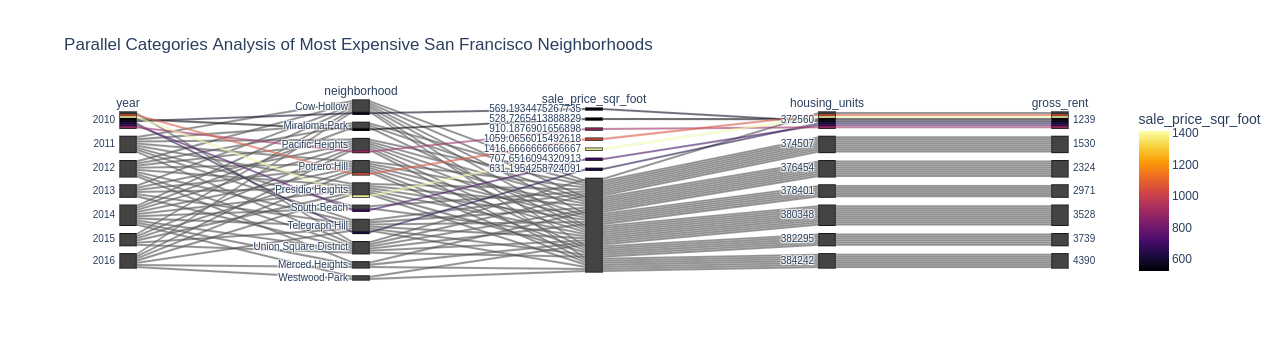

In [30]:
# parallel_categories()
parallel_categories()

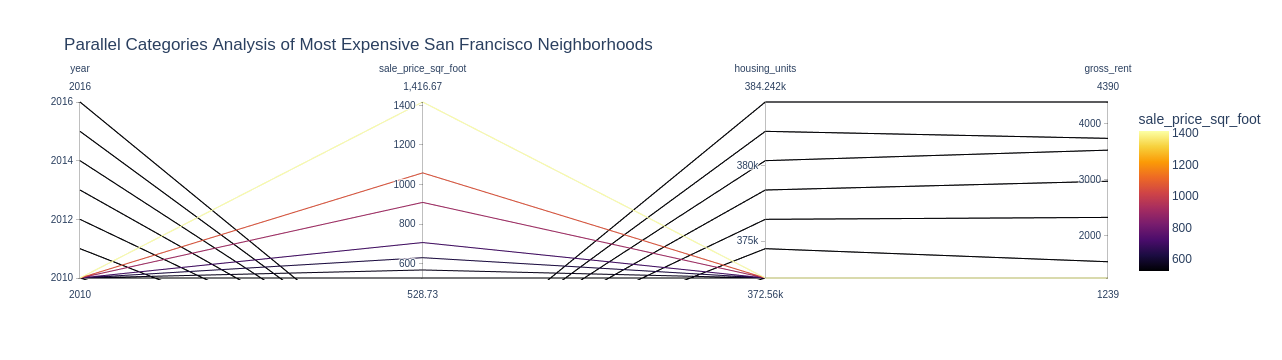

In [47]:
# parallel_coordinates()
parallel_coordinates()

In [48]:
# sunburst()
sunburst()

BokehModel(combine_events=True, render_bundle={'docs_json': {'5ef3fe01-91e5-4d4b-b576-0ac3f456224e': {'defs': …

Plotly(Figure)